In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import nbinom 
import math 
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#Load datasets
train_df = pd.read_excel('train__1_.xlsx')
test_df = pd.read_excel('test__1_.xlsx')

In [3]:
#Change format of date column 
train_df['Date'] = pd.to_datetime(train_df['Date'], dayfirst=True)
test_df['Date'] = pd.to_datetime(test_df['Date'], dayfirst=True)

In [4]:
train_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners
0,2826,793,2005-04-02,410,908,2.0,0.0,15,1
1,2827,793,2005-04-02,338,597,3.0,2.0,3,6
2,2828,793,2005-04-02,1364,246,2.0,3.0,13,2
3,2829,793,2005-04-02,1088,1397,1.0,0.0,2,5
4,2830,793,2005-04-02,830,1412,2.0,3.0,3,6


In [5]:
#Add column with total number of corners per match 
train_df['Total_Corners'] = train_df['Home_Corners'] + train_df['Away_Corners']

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23830 entries, 0 to 23829
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   MatchId        23830 non-null  int64         
 1   LeagueId       23830 non-null  int64         
 2   Date           23830 non-null  datetime64[ns]
 3   HomeTeamId     23830 non-null  int64         
 4   AwayTeamId     23830 non-null  int64         
 5   Home_Goals     23822 non-null  float64       
 6   Away_Goals     23822 non-null  float64       
 7   Home_Corners   23830 non-null  int64         
 8   Away_Corners   23830 non-null  int64         
 9   Total_Corners  23830 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7)
memory usage: 1.8 MB


In [7]:
train_df.describe()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners
count,23830.000000,23830.000000,23830,23830.000000,23830.000000,23822.000000,23822.000000,23830.000000,23830.000000,23830.000000
mean,152335.821024,783.848091,2008-05-22 23:08:45.421737216,1052.965044,1052.514394,1.494333,1.109647,5.726060,4.493412,10.219471
min,2826.000000,729.000000,2005-04-02 00:00:00,192.000000,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93111.250000,764.000000,2007-02-24 00:00:00,548.000000,548.000000,1.000000,0.000000,4.000000,3.000000,8.000000
50%,151201.500000,795.000000,2008-07-13 00:00:00,916.000000,914.000000,1.000000,1.000000,5.000000,4.000000,10.000000
75%,211599.750000,811.000000,2009-10-02 00:00:00,1239.000000,1239.000000,2.000000,2.000000,7.000000,6.000000,12.000000
max,310017.000000,816.000000,2010-12-19 00:00:00,9998.000000,9998.000000,9.000000,8.000000,21.000000,19.000000,25.000000
std,81023.025311,29.941558,NaN,932.207670,930.976589,1.234224,1.084321,2.844714,2.505376,3.451955


In [8]:
#Check missing values
train_df.isnull().sum()

MatchId          0
LeagueId         0
Date             0
HomeTeamId       0
AwayTeamId       0
Home_Goals       8
Away_Goals       8
Home_Corners     0
Away_Corners     0
Total_Corners    0
dtype: int64

In [9]:
#Drop rows with missing values
train_df[train_df.isnull().any(axis=1)]

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners
21232,265278,811,2010-07-03,353,795,NaN,NaN,6,3,9
21309,266609,793,2010-07-07,410,826,NaN,NaN,8,4,12
21504,269617,793,2010-07-24,1397,1088,NaN,NaN,14,6,20
21650,272227,729,2010-08-04,1118,1302,NaN,NaN,13,5,18
21905,273965,811,2010-08-21,1386,641,NaN,NaN,3,10,13
22359,280049,813,2010-09-11,1262,1056,NaN,NaN,3,3,6
22658,283918,801,2010-09-25,1096,238,NaN,NaN,1,2,3
23555,301278,781,2010-11-14,613,541,NaN,NaN,3,1,4


In [10]:
train_df = train_df.dropna()

In [11]:
train_df

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners
0,2826,793,2005-04-02,410,908,2.0,0.0,15,1,16
1,2827,793,2005-04-02,338,597,3.0,2.0,3,6,9
2,2828,793,2005-04-02,1364,246,2.0,3.0,13,2,15
3,2829,793,2005-04-02,1088,1397,1.0,0.0,2,5,7
4,2830,793,2005-04-02,830,1412,2.0,3.0,3,6,9
...,...,...,...,...,...,...,...,...,...,...
23825,307623,800,2010-12-18,1326,1399,1.0,0.0,4,5,9
23826,307624,800,2010-12-18,944,8291,2.0,1.0,3,4,7
23827,307625,800,2010-12-18,4704,4705,4.0,0.0,4,4,8
23828,307626,800,2010-12-18,2113,250,1.0,1.0,5,5,10


In [12]:
test_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Unnamed: 8,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,2011-04-01,342,694,9.5,1.790,1.80,NaN,NaN,NaN,NaN,NaN,NaN
1,2,741,2011-04-01,1424,270,11.5,1.920,2.00,NaN,NaN,NaN,NaN,NaN,NaN
2,3,729,2011-04-01,691,1137,10.5,1.970,1.87,NaN,NaN,NaN,NaN,NaN,NaN
3,4,729,2011-04-01,787,808,11.0,2.075,1.77,NaN,NaN,NaN,NaN,NaN,NaN
4,5,741,2011-04-01,784,1117,12.0,2.020,1.86,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
test_df.isnull().sum()

MatchId         0
LeagueId        0
Date            0
HomeTeamId      0
AwayTeamId      0
Line            0
Over            0
Under           0
Unnamed: 8    341
P(Under)      341
P(At)         341
P(Over)       341
Bet (U/O)     341
Stake         341
dtype: int64

In [14]:
test_df.describe()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Unnamed: 8,P(Under),P(At),P(Over),Bet (U/O),Stake
count,341.000000,341.000000,341,341.000000,341.000000,341.000000,341.000000,341.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,171.000000,774.472141,2011-04-27 12:06:20.058651136,938.642229,937.750733,10.428152,1.965531,1.903501,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,729.000000,2011-04-01 00:00:00,192.000000,192.000000,9.000000,1.640000,1.610000,NaN,NaN,NaN,NaN,NaN,NaN
25%,86.000000,741.000000,2011-04-09 00:00:00,526.000000,489.000000,10.000000,1.900000,1.850000,NaN,NaN,NaN,NaN,NaN,NaN
50%,171.000000,793.000000,2011-04-30 00:00:00,870.000000,834.000000,10.500000,1.950000,1.900000,NaN,NaN,NaN,NaN,NaN,NaN
75%,256.000000,801.000000,2011-05-14 00:00:00,1237.000000,1223.000000,11.000000,2.010000,1.960000,NaN,NaN,NaN,NaN,NaN,NaN
max,341.000000,811.000000,2011-05-23 00:00:00,5525.000000,5525.000000,12.000000,2.351000,2.220000,NaN,NaN,NaN,NaN,NaN,NaN
std,98.582453,29.671188,NaN,625.878475,690.841945,0.710198,0.098355,0.081779,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MatchId     341 non-null    int64         
 1   LeagueId    341 non-null    int64         
 2   Date        341 non-null    datetime64[ns]
 3   HomeTeamId  341 non-null    int64         
 4   AwayTeamId  341 non-null    int64         
 5   Line        341 non-null    float64       
 6   Over        341 non-null    float64       
 7   Under       341 non-null    float64       
 8   Unnamed: 8  0 non-null      float64       
 9   P(Under)    0 non-null      float64       
 10  P(At)       0 non-null      float64       
 11  P(Over)     0 non-null      float64       
 12  Bet (U/O)   0 non-null      float64       
 13  Stake       0 non-null      float64       
dtypes: datetime64[ns](1), float64(9), int64(4)
memory usage: 37.4 KB


In [16]:
#Explore the correlation matrix to see which variables can be used to predict total corners and avoid multicolinarity 
train_df.corr().round(2)

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners
MatchId,1.00,0.02,0.99,0.12,0.12,0.00,0.03,0.05,0.06,0.08
LeagueId,0.02,1.00,0.02,0.09,0.09,-0.03,0.00,-0.03,-0.00,-0.03
Date,0.99,0.02,1.00,0.12,0.12,0.01,0.03,0.06,0.06,0.09
HomeTeamId,0.12,0.09,0.12,1.00,0.16,-0.01,0.01,-0.00,0.00,0.00
AwayTeamId,0.12,0.09,0.12,0.16,1.00,0.01,-0.01,-0.01,0.01,-0.00
Home_Goals,0.00,-0.03,0.01,-0.01,0.01,1.00,-0.01,-0.03,0.01,-0.02
Away_Goals,0.03,0.00,0.03,0.01,-0.01,-0.01,1.00,0.01,0.00,0.01
Home_Corners,0.05,-0.03,0.06,-0.00,-0.01,-0.03,0.01,1.00,-0.17,0.70
Away_Corners,0.06,-0.00,0.06,0.00,0.01,0.01,0.00,-0.17,1.00,0.58
Total_Corners,0.08,-0.03,0.09,0.00,-0.00,-0.02,0.01,0.70,0.58,1.00


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'MatchId'),
  Text(1.5, 0, 'LeagueId'),
  Text(2.5, 0, 'Date'),
  Text(3.5, 0, 'HomeTeamId'),
  Text(4.5, 0, 'AwayTeamId'),
  Text(5.5, 0, 'Home_Goals'),
  Text(6.5, 0, 'Away_Goals'),
  Text(7.5, 0, 'Home_Corners'),
  Text(8.5, 0, 'Away_Corners'),
  Text(9.5, 0, 'Total_Corners')])

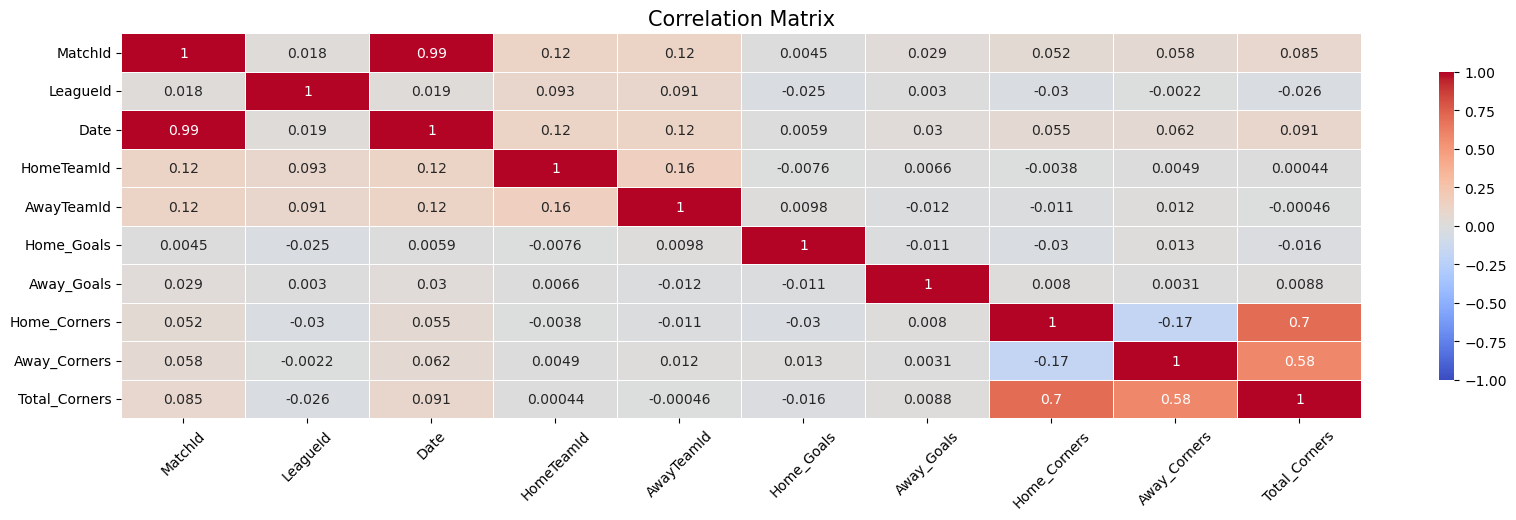

In [17]:
plt.figure(figsize=(20, 5))
sns.heatmap(train_df.corr(), cmap='coolwarm', vmax=1, vmin=-1, 
            center=0, square=False, linewidths=.5, 
            cbar_kws={"shrink": .8}, annot=True)
plt.title('Correlation Matrix', fontsize=15)

# rotate the ticklabels for easier reading
plt.xticks(rotation=45)

array([[<Axes: title={'center': 'MatchId'}>,
        <Axes: title={'center': 'LeagueId'}>,
        <Axes: title={'center': 'Date'}>],
       [<Axes: title={'center': 'HomeTeamId'}>,
        <Axes: title={'center': 'AwayTeamId'}>,
        <Axes: title={'center': 'Home_Goals'}>],
       [<Axes: title={'center': 'Away_Goals'}>,
        <Axes: title={'center': 'Home_Corners'}>,
        <Axes: title={'center': 'Away_Corners'}>],
       [<Axes: title={'center': 'Total_Corners'}>, <Axes: >, <Axes: >]],
      dtype=object)

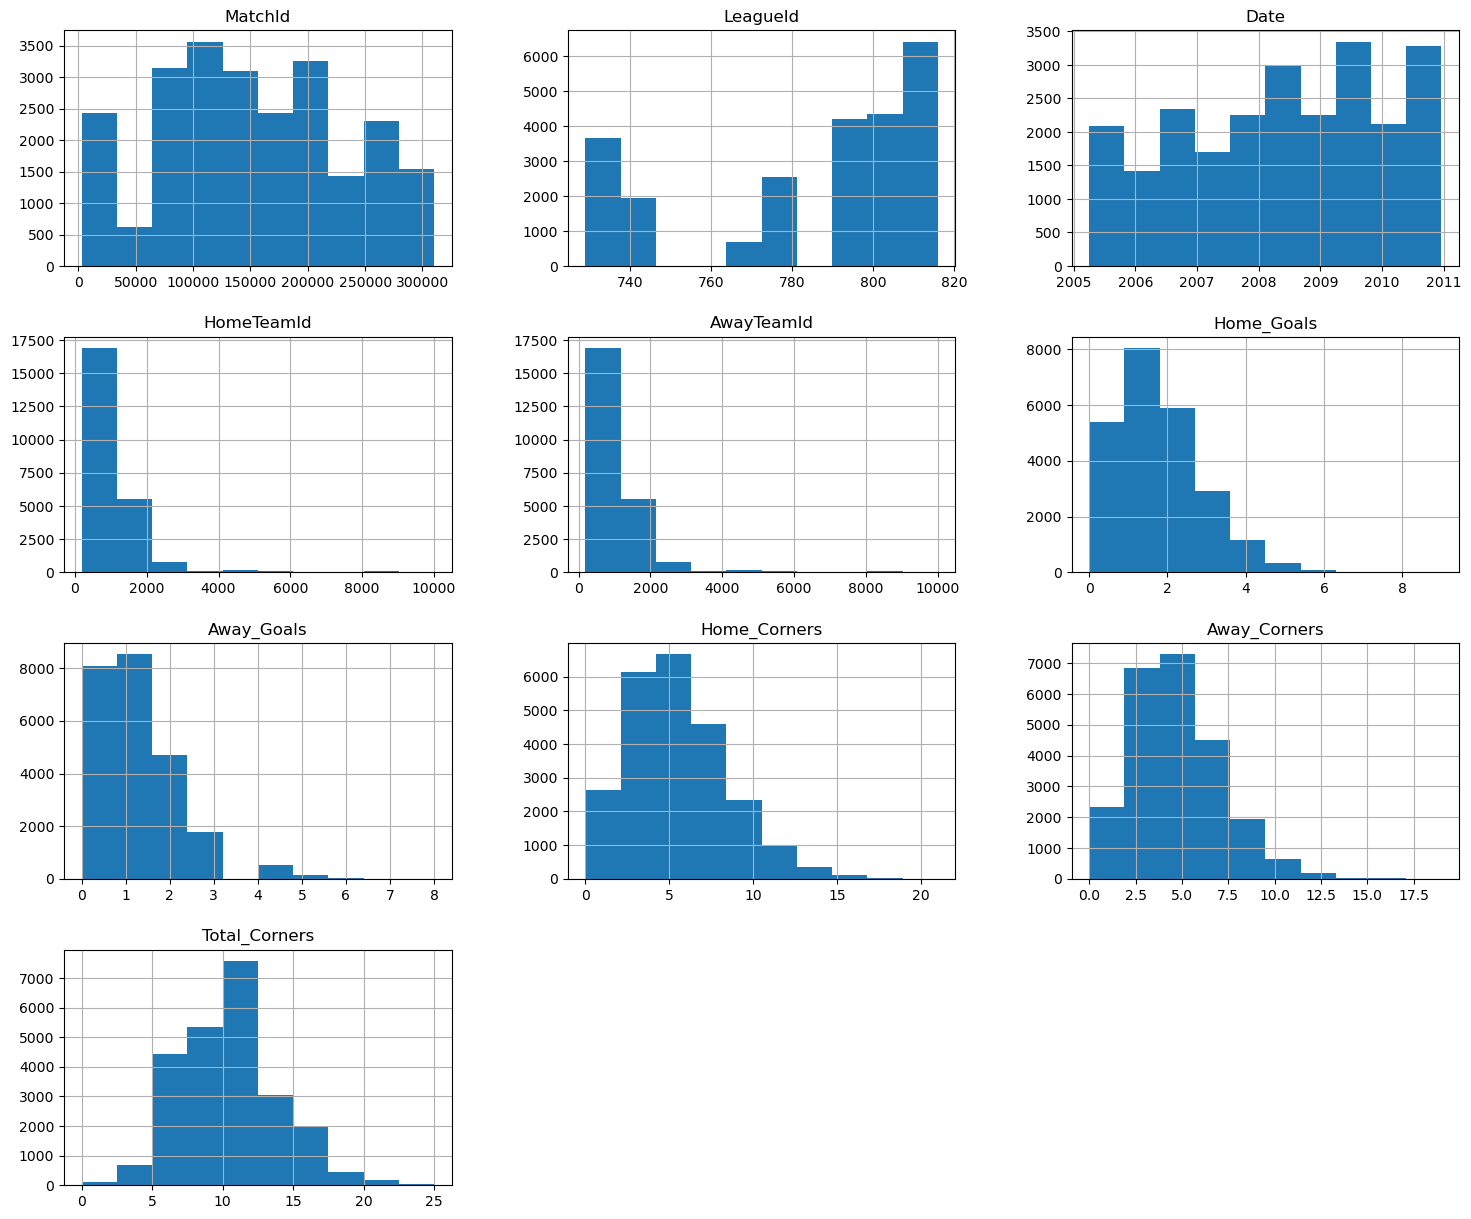

In [18]:
#Look at the distributions of our data
train_df.hist(figsize=(18, 15))

c:\Users\edgar\miniconda3\envs\primary\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


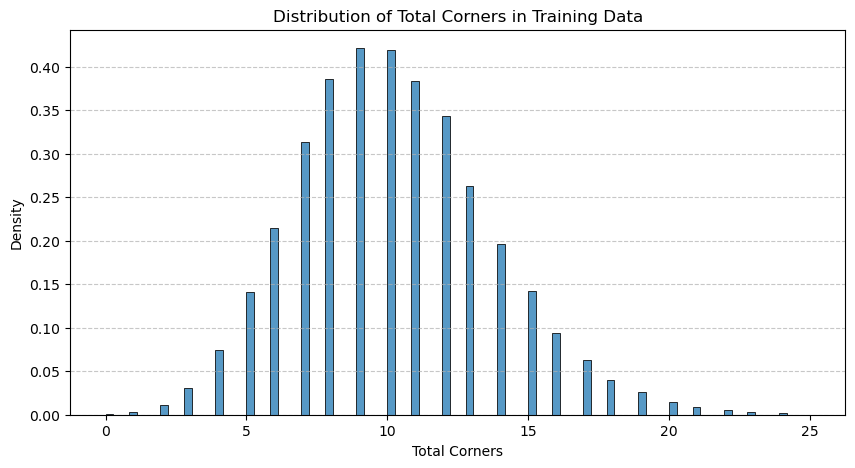

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df["Total_Corners"], stat="density")
plt.xlabel("Total Corners")
plt.ylabel("Density")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title("Distribution of Total Corners in Training Data")
plt.show()

In [20]:
mean = train_df['Total_Corners'].mean()
variance = train_df['Total_Corners'].var()
print('Mean:', mean, 'Variance:', variance)

Mean: 10.219335068424146 Variance: 11.908357091116404


c:\Users\edgar\miniconda3\envs\primary\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


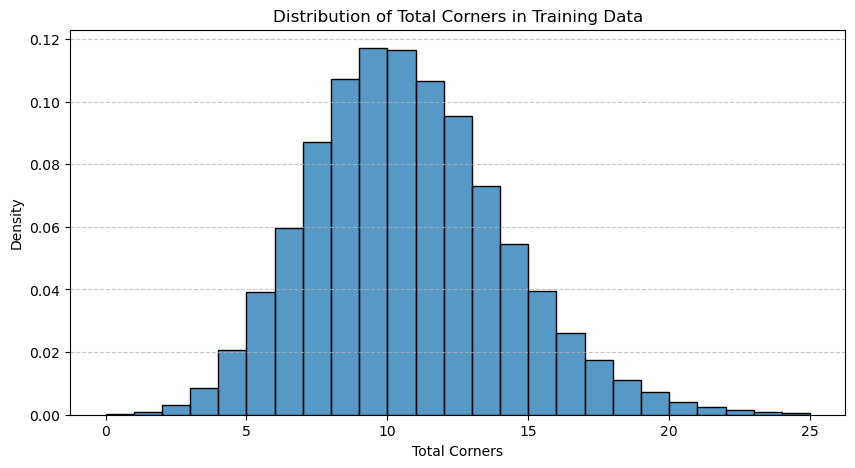

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df["Total_Corners"], bins=25, stat="density")
plt.xlabel("Total Corners")
plt.ylabel("Density")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title("Distribution of Total Corners in Training Data")
plt.show()

In [22]:
# Compute overall home averages for corners and goals for each team
home_averages = train_df.groupby('HomeTeamId').agg({'Home_Corners': 'mean', 'Home_Goals': 'mean'}).rename(columns={'Home_Corners': 'Home_Corner_Avg',
    'Home_Goals': 'Home_Goals_Avg'}).reset_index()

# Compute overall away averages (for corners and goals) for each team
away_averages = train_df.groupby('AwayTeamId').agg({'Away_Corners': 'mean','Away_Goals': 'mean'}).rename(columns={'Away_Corners': 'Away_Corner_Avg',
    'Away_Goals': 'Away_Goals_Avg'}).reset_index()

# Merge overall averages back into the training set
train_df = train_df.merge(home_averages, on='HomeTeamId', how='left')
train_df = train_df.merge(away_averages, left_on='AwayTeamId', right_on='AwayTeamId', how='left')

# For the test set, merge the same averages 
test_df = test_df.merge(home_averages, on='HomeTeamId', how='left')
test_df = test_df.merge(away_averages, left_on='AwayTeamId', right_on='AwayTeamId', how='left')

In [23]:
# Function to compute rolling features on the training data
def compute_rolling_features(df, team_col, target_col, new_col, window):
    # Ensure the DataFrame is sorted by team and Date for proper ordering
    df = df.sort_values(by=[team_col, 'Date'])
    
    # Compute the rolling mean shifted by 1 (to exclude the current match)
    df[new_col] = df.groupby(team_col)[target_col].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    
    # Compute the overall average for the target column for each team
    overall_avg = df.groupby(team_col)[target_col].transform('mean')
    
    # Fill missing rolling values (first match for each team) with the overall average
    df[new_col] = df[new_col].fillna(overall_avg)
    
    return df

# Set window size 
window_size = 5

# Compute Home team rolling averages for corners in training data
train_df = compute_rolling_features(train_df, 'HomeTeamId', 'Home_Corners', 'Home_Corners_Rolling', window_size)
train_df = compute_rolling_features(train_df, 'HomeTeamId', 'Home_Goals', 'Home_Goals_Rolling', window_size)

# Compute Away team rolling averages for goals in training data
train_df = compute_rolling_features(train_df, 'AwayTeamId', 'Away_Corners', 'Away_Corners_Rolling', window_size)
train_df = compute_rolling_features(train_df, 'AwayTeamId', 'Away_Goals', 'Away_Goals_Rolling', window_size)

# Now, for the test dataset, we use the last available rolling averages from the training data
# These represent the most recent performance of each team prior to the test match.

# For Home teams:
# Extract the last available rolling average for Home_Corners_Rolling and Home_Goals_Rolling
home_corners_last = train_df.groupby('HomeTeamId')['Home_Corners_Rolling'].last().reset_index()

home_goals_last = train_df.groupby('HomeTeamId')['Home_Goals_Rolling'].last().reset_index()

# Merge these into the test set based on HomeTeamId
test_df = test_df.merge(home_corners_last, on='HomeTeamId', how='left')
test_df = test_df.merge(home_goals_last, on='HomeTeamId', how='left')

# For Away teams:
# Extract the last available rolling average for Away_Corners_Rolling and Away_Goals_Rolling
away_corners_last = train_df.groupby('AwayTeamId')['Away_Corners_Rolling'].last().reset_index()

away_goals_last = train_df.groupby('AwayTeamId')['Away_Goals_Rolling'].last().reset_index()

# Merge these into the test set based on AwayTeamId
test_df = test_df.merge(away_corners_last, left_on='AwayTeamId', right_on='AwayTeamId', how='left')
test_df = test_df.merge(away_goals_last, left_on='AwayTeamId', right_on='AwayTeamId', how='left')

In [24]:
train_df.columns

Index(['MatchId', 'LeagueId', 'Date', 'HomeTeamId', 'AwayTeamId', 'Home_Goals',
       'Away_Goals', 'Home_Corners', 'Away_Corners', 'Total_Corners',
       'Home_Corner_Avg', 'Home_Goals_Avg', 'Away_Corner_Avg',
       'Away_Goals_Avg', 'Home_Corners_Rolling', 'Home_Goals_Rolling',
       'Away_Corners_Rolling', 'Away_Goals_Rolling'],
      dtype='object')

In [25]:
# Compute league-level averages for corners and goals
league_features = train_df.groupby('LeagueId').agg({'Total_Corners': 'mean', 'Home_Goals': 'mean', 'Away_Goals': 'mean'}).rename(columns={'Total_Corners': 'League_Avg_Corners', 
    'Home_Goals': 'League_Avg_Home_Goals','Away_Goals': 'League_Avg_Away_Goals'}).reset_index()

# Merge league-level averages back into the training set
train_df = train_df.merge(league_features, on='LeagueId', how='left')

# Merge these league features into the test dataset based on LeagueId
test_df = test_df.merge(league_features, on='LeagueId', how='left')


In [26]:
train_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Total_Corners,...,Home_Goals_Avg,Away_Corner_Avg,Away_Goals_Avg,Home_Corners_Rolling,Home_Goals_Rolling,Away_Corners_Rolling,Away_Goals_Rolling,League_Avg_Corners,League_Avg_Home_Goals,League_Avg_Away_Goals
0,7922,811,2005-06-11,1071,192,1.0,1.0,6,1,7,...,1.230769,3.674157,0.966292,5.241758,1.230769,3.674157,0.966292,9.484848,1.411019,1.019835
1,8732,811,2005-06-25,853,192,0.0,0.0,5,7,12,...,1.936170,3.674157,0.966292,5.000000,3.000000,1.000000,1.000000,9.484848,1.411019,1.019835
2,10605,811,2005-08-03,795,192,1.0,1.0,8,4,12,...,1.411111,3.674157,0.966292,5.333333,2.333333,4.000000,0.500000,9.484848,1.411019,1.019835
3,15642,811,2005-09-24,1328,192,1.0,2.0,7,2,9,...,1.256757,3.674157,0.966292,4.500000,1.000000,4.000000,0.666667,9.484848,1.411019,1.019835
4,17073,811,2005-10-09,316,192,1.0,0.0,9,1,10,...,1.279070,3.674157,0.966292,6.000000,0.250000,3.500000,1.000000,9.484848,1.411019,1.019835


In [27]:
test_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Unnamed: 8,P(Under),...,Home_Goals_Avg,Away_Corner_Avg,Away_Goals_Avg,Home_Corners_Rolling,Home_Goals_Rolling,Away_Corners_Rolling,Away_Goals_Rolling,League_Avg_Corners,League_Avg_Home_Goals,League_Avg_Away_Goals
0,1,741,2011-04-01,342,694,9.5,1.790,1.80,NaN,NaN,...,1.736264,5.147368,2.273684,3.4,2.0,4.0,2.0,10.624033,1.634863,1.140278
1,2,741,2011-04-01,1424,270,11.5,1.920,2.00,NaN,NaN,...,1.970000,4.673267,1.237624,5.0,3.0,5.8,1.0,10.624033,1.634863,1.140278
2,3,729,2011-04-01,691,1137,10.5,1.970,1.87,NaN,NaN,...,1.345455,4.738636,1.045455,5.6,1.2,3.2,1.2,10.890633,1.569859,1.156986
3,4,729,2011-04-01,787,808,11.0,2.075,1.77,NaN,NaN,...,1.650485,5.525773,1.432990,5.2,2.2,5.2,2.2,10.890633,1.569859,1.156986
4,5,741,2011-04-01,784,1117,12.0,2.020,1.86,NaN,NaN,...,3.179775,4.531915,1.053191,9.2,2.2,5.0,0.4,10.624033,1.634863,1.140278


In [28]:
target = 'Total_Corners'
features = ['Home_Corner_Avg', 'Home_Goals_Avg', 'Away_Corner_Avg', 'Away_Goals_Avg', 'Home_Corners_Rolling', 'Home_Goals_Rolling',
            'Away_Corners_Rolling', 'Away_Goals_Rolling', 'League_Avg_Corners', 'League_Avg_Home_Goals', 'League_Avg_Away_Goals']
selected_cols = [target] + features
train_df[selected_cols].corr()


,Total_Corners,Home_Corner_Avg,Home_Goals_Avg,Away_Corner_Avg,Away_Goals_Avg,Home_Corners_Rolling,Home_Goals_Rolling,Away_Corners_Rolling,Away_Goals_Rolling,League_Avg_Corners,League_Avg_Home_Goals,League_Avg_Away_Goals
Total_Corners,1.000000,0.161328,0.046427,0.134355,0.028578,0.079266,0.029921,0.070310,0.017530,0.158072,0.062313,0.082860
Home_Corner_Avg,0.161328,1.000000,0.525550,0.199311,0.109522,0.453373,0.253995,0.077596,0.040400,0.421561,0.277247,0.238414
Home_Goals_Avg,0.046427,0.525550,1.000000,0.060879,0.105072,0.241677,0.482731,0.018428,0.032956,0.140778,0.347063,0.254169
Away_Corner_Avg,0.134355,0.199311,0.060879,1.000000,0.541307,0.102559,0.025327,0.445932,0.239454,0.507437,0.178646,0.319349
Away_Goals_Avg,0.028578,0.109522,0.105072,0.541307,1.000000,0.047462,0.042632,0.240503,0.442247,0.193948,0.298834,0.350371
Home_Corners_Rolling,0.079266,0.453373,0.241677,0.102559,0.047462,1.000000,0.106568,0.069350,0.040257,0.189626,0.112758,0.101204
Home_Goals_Rolling,0.029921,0.253995,0.482731,0.025327,0.042632,0.106568,1.000000,0.019517,0.025280,0.062084,0.143619,0.105923
Away_Corners_Rolling,0.070310,0.077596,0.018428,0.445932,0.240503,0.069350,0.019517,1.000000,0.147364,0.219461,0.053127,0.122739
Away_Goals_Rolling,0.017530,0.040400,0.032956,0.239454,0.442247,0.040257,0.025280,0.147364,1.000000,0.078055,0.104696,0.137899
League_Avg_Corners,0.158072,0.421561,0.140778,0.507437,0.193948,0.189626,0.062084,0.219461,0.078055,1.000000,0.394207,0.524192


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'Total_Corners'),
  Text(1.5, 0, 'Home_Corner_Avg'),
  Text(2.5, 0, 'Home_Goals_Avg'),
  Text(3.5, 0, 'Away_Corner_Avg'),
  Text(4.5, 0, 'Away_Goals_Avg'),
  Text(5.5, 0, 'Home_Corners_Rolling'),
  Text(6.5, 0, 'Home_Goals_Rolling'),
  Text(7.5, 0, 'Away_Corners_Rolling'),
  Text(8.5, 0, 'Away_Goals_Rolling'),
  Text(9.5, 0, 'League_Avg_Corners'),
  Text(10.5, 0, 'League_Avg_Home_Goals'),
  Text(11.5, 0, 'League_Avg_Away_Goals')])

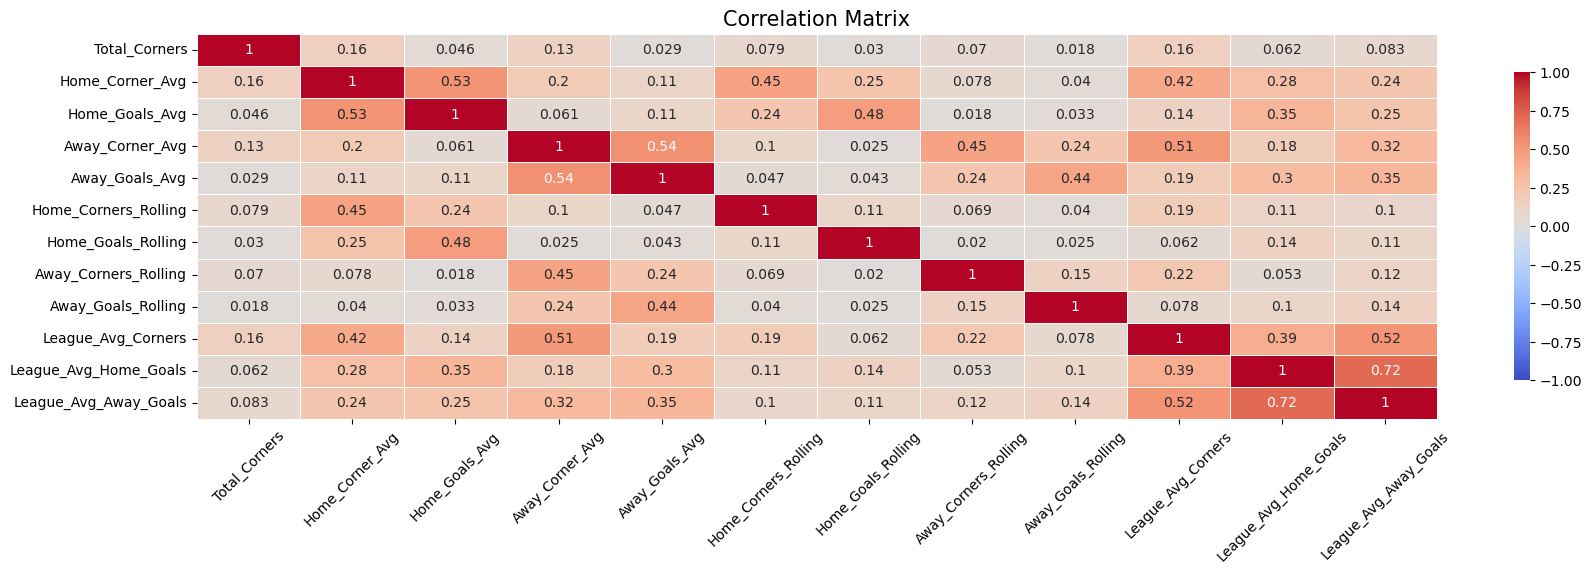

In [29]:
plt.figure(figsize=(20, 5))
sns.heatmap(train_df[selected_cols].corr(), cmap='coolwarm', vmax=1, vmin=-1, 
            center=0, square=False, linewidths=.5, 
            cbar_kws={"shrink": .8}, annot=True)
plt.title('Correlation Matrix', fontsize=15)

# rotate the ticklabels for easier reading
plt.xticks(rotation=45)

array([[<Axes: title={'center': 'Home_Corner_Avg'}>,
        <Axes: title={'center': 'Home_Goals_Avg'}>,
        <Axes: title={'center': 'Away_Corner_Avg'}>],
       [<Axes: title={'center': 'Away_Goals_Avg'}>,
        <Axes: title={'center': 'Home_Corners_Rolling'}>,
        <Axes: title={'center': 'Home_Goals_Rolling'}>],
       [<Axes: title={'center': 'Away_Corners_Rolling'}>,
        <Axes: title={'center': 'Away_Goals_Rolling'}>,
        <Axes: title={'center': 'League_Avg_Corners'}>],
       [<Axes: title={'center': 'League_Avg_Home_Goals'}>,
        <Axes: title={'center': 'League_Avg_Away_Goals'}>, <Axes: >]],
      dtype=object)

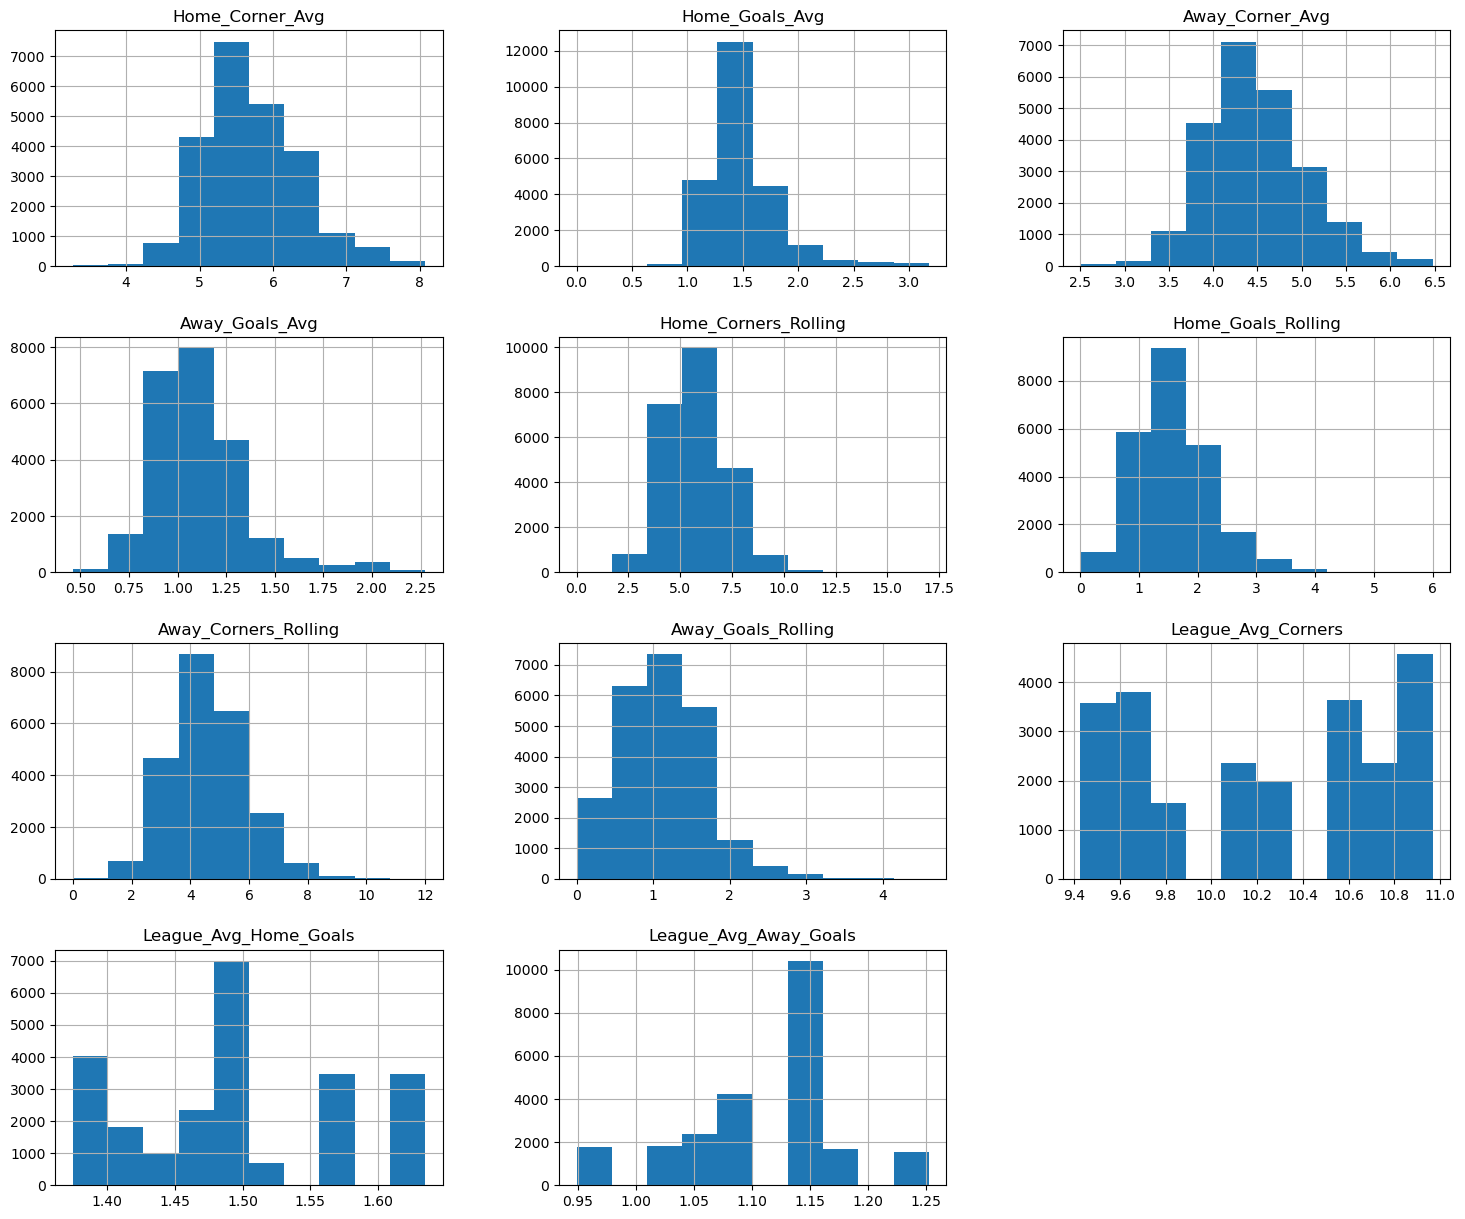

In [30]:
X_train = train_df[features]
y_train = train_df[target]

X_train.hist(figsize=(18,15))

In [31]:
#Define features & target
features = ['Home_Corner_Avg', 'Home_Goals_Avg', 'Away_Corner_Avg', 'Away_Goals_Avg','Home_Corners_Rolling', 'Home_Goals_Rolling', 'Away_Corners_Rolling', 'Away_Goals_Rolling',
            'League_Avg_Corners', 'League_Avg_Home_Goals', 'League_Avg_Away_Goals']
target = 'Total_Corners'

#Prepare data
X_train = train_df[features]
y_train = train_df[target]

#Add constant for intercept
X_train = sm.add_constant(X_train)

#Split dataset: First 80% for training, last 20% for validation
split_index = int(len(X_train) * 0.8)
X_train_glm1, y_train_glm1 = X_train.iloc[:split_index], y_train.iloc[:split_index]
X_val_glm1, y_val_glm1 = X_train.iloc[split_index:], y_train.iloc[split_index:]

#Compute dispersion parameter for Negative Binomial
mean_train1 = y_train_glm1.mean()
variance_train1 = y_train_glm1.var()
dispersion_param1 = (variance_train1 - mean_train1) / mean_train1**2

#Fit Negative Binomial Model on training data only
glm_model1 = sm.GLM(y_train_glm1, X_train_glm1, family=sm.families.NegativeBinomial(alpha=dispersion_param1)).fit()

#Display model summary
glm_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Total_Corners   No. Observations:                19057
Model:                            GLM   Df Residuals:                    19045
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49914.
Date:                Tue, 25 Feb 2025   Deviance:                       18609.
Time:                        23:36:48   Pearson chi2:                 1.82e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04070
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.3536      0.058     23.417      0.000       1.240       1.467
Home_Corner_Avg           0.0689      0.005     13.444      0.000       0.059       0.079
Home_Goals_Avg           -0.0551      0.011     -5.230      0.000      -0.076      -0.034
Away_Corner_Avg           0.0563      0.006      8.673      0.000       0.044       0.069
Away_Goals_Avg           -0.0841      0.014     -6.087      0.000      -0.111      -0.057
Home_Corners_Rolling      0.0007      0.002      0.375      0.708      -0.003       0.004
Home_Goals_Rolling        0.0085      0.004      1.979      0.048     8.1e-05       0.017
Away_Corners_Rolling      0.0039      0.002      1.817      0.069      -0.000       0.008
Away_Goals_Rolling        0.0017      0.005      0.336      0.737      -0.008       0.011
League_Avg_Corners        0.0342      0.006      5.375      0.000       0.022       0.047
League_Avg_Home_Goals     0.0079      0.046      0.172      0.864      -0.083       0.098
League_Avg_Away_Goals     0.0869      0.055      1.576      0.115      -0.021       0.195
=========================================================================================
"""

In [32]:
#Predict on validation set
y_val_pred1 = glm_model1.predict(X_val_glm1)

#Compute RMSE on validation set
rmse1 = np.sqrt(mean_squared_error(y_val_glm1, y_val_pred1))
print(f"GLM Validation RMSE: {rmse1:.4f}")  # Prints RMSE on validation set

# Apply model to test data 
X_test = test_df[features]
X_test = sm.add_constant(X_test)
test_df["Expected_Corners1"] = glm_model1.predict(X_test)

GLM Validation RMSE: 3.4181


In [33]:
#Define features & target
features2 = ['Home_Corner_Avg', 'Home_Goals_Avg', 'Away_Corner_Avg', 'Away_Goals_Avg', 'Home_Goals_Rolling', 'League_Avg_Corners']
target = 'Total_Corners'

#Prepare data
X_train2 = train_df[features2]
y_train = train_df[target]

#Add constant for intercept
X_train2 = sm.add_constant(X_train2)

#Split dataset: First 80% for training, last 20% for validation
split_index = int(len(X_train2) * 0.8)
X_train_glm2, y_train_glm2 = X_train2.iloc[:split_index], y_train.iloc[:split_index]
X_val_glm2, y_val_glm2 = X_train2.iloc[split_index:], y_train.iloc[split_index:]

#Compute dispersion parameter for Negative Binomial
mean_train2 = y_train_glm1.mean()
variance_train2 = y_train_glm1.var()
dispersion_param2 = (variance_train2 - mean_train2) / mean_train1**2

#Fit Negative Binomial Model on training data only
glm_model2 = sm.GLM(y_train_glm2, X_train_glm2, family=sm.families.NegativeBinomial(alpha=dispersion_param1)).fit()

#Display model summary
glm_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Total_Corners   No. Observations:                19057
Model:                            GLM   Df Residuals:                    19050
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49918.
Date:                Tue, 25 Feb 2025   Deviance:                       18617.
Time:                        23:36:48   Pearson chi2:                 1.83e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04028
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.3966      0.048     29.377      0.000       1.303       1.490
Home_Corner_Avg        0.0684      0.005     14.439      0.000       0.059       0.078
Home_Goals_Avg        -0.0501      0.010     -4.942      0.000      -0.070      -0.030
Away_Corner_Avg        0.0587      0.006      9.764      0.000       0.047       0.070
Away_Goals_Avg        -0.0739      0.012     -6.100      0.000      -0.098      -0.050
Home_Goals_Rolling     0.0085      0.004      1.970      0.049    4.41e-05       0.017
League_Avg_Corners     0.0403      0.006      7.045      0.000       0.029       0.052
======================================================================================
"""

In [34]:
#Predict on validation set
y_val_pred2 = glm_model2.predict(X_val_glm2)

#Compute RMSE on validation set
rmse2 = np.sqrt(mean_squared_error(y_val_glm2, y_val_pred2))
print(f"GLM Validation RMSE: {rmse2:.4f}")  # Prints RMSE on validation set

# Apply model to test data 
X_test2 = test_df[features2]
X_test2 = sm.add_constant(X_test2)
test_df["Expected_Corners2"] = glm_model2.predict(X_test2)

GLM Validation RMSE: 3.4189


C:\Users\edgar\AppData\Local\Temp\ipykernel_63728\1136471577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_transf[feature] = np.log1p(X_train_transf[feature])
C:\Users\edgar\AppData\Local\Temp\ipykernel_63728\1136471577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_transf[feature] = np.log1p(X_test_transf[feature])


array([[<Axes: title={'center': 'Home_Corner_Avg'}>,
        <Axes: title={'center': 'Home_Goals_Avg'}>,
        <Axes: title={'center': 'Away_Corner_Avg'}>],
       [<Axes: title={'center': 'Away_Goals_Avg'}>,
        <Axes: title={'center': 'Home_Corners_Rolling'}>,
        <Axes: title={'center': 'Home_Goals_Rolling'}>],
       [<Axes: title={'center': 'Away_Corners_Rolling'}>,
        <Axes: title={'center': 'Away_Goals_Rolling'}>,
        <Axes: title={'center': 'League_Avg_Corners'}>],
       [<Axes: title={'center': 'League_Avg_Home_Goals'}>,
        <Axes: title={'center': 'League_Avg_Away_Goals'}>, <Axes: >]],
      dtype=object)

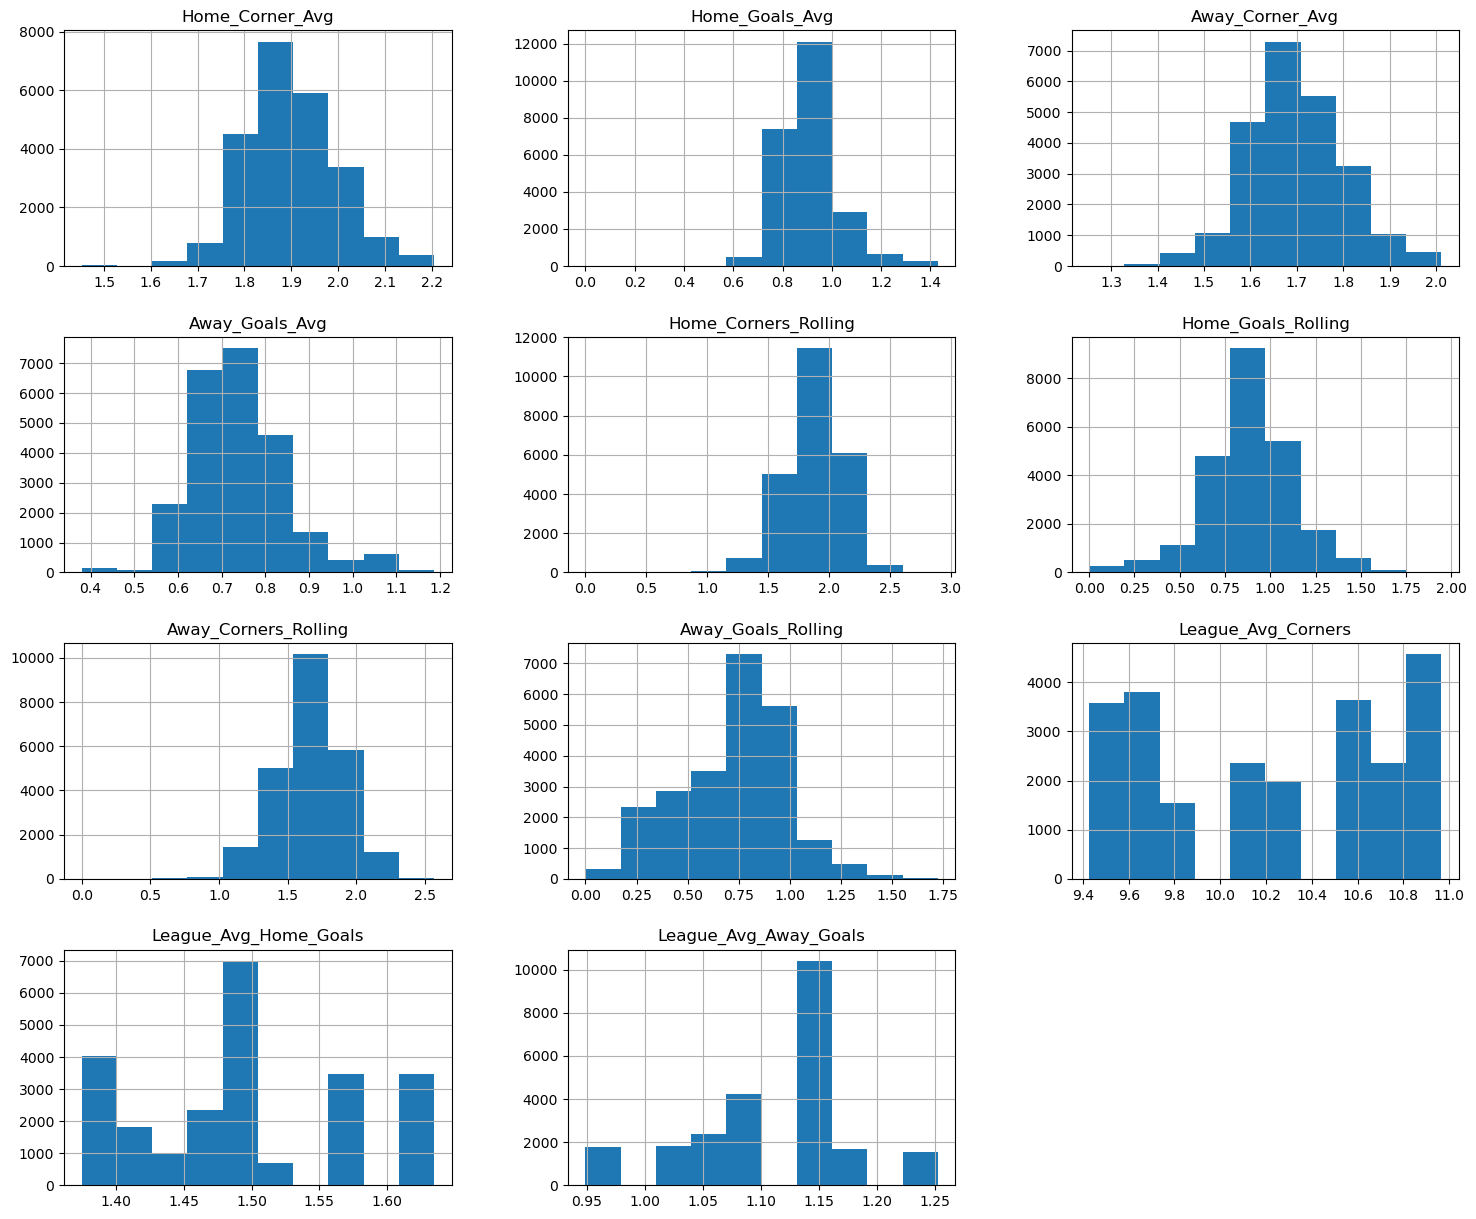

In [35]:
X_train_transf = train_df[features]
y_train  =train_df[target]

X_test_transf = test_df[features]
features_trans = ['Home_Corner_Avg', 'Home_Goals_Avg', 'Away_Corner_Avg', 'Away_Goals_Avg', 'Home_Corners_Rolling', 'Home_Goals_Rolling',
            'Away_Corners_Rolling', 'Away_Goals_Rolling']
for feature in features_trans:
    X_train_transf[feature] = np.log1p(X_train_transf[feature])
    X_test_transf[feature] = np.log1p(X_test_transf[feature])
X_train_transf.hist(figsize=(18,15))


In [36]:
#Define features & target
features3 = ['Home_Corner_Avg', 'Home_Goals_Avg', 'Away_Corner_Avg', 'Away_Goals_Avg','Home_Corners_Rolling', 'Home_Goals_Rolling', 'Away_Corners_Rolling', 'Away_Goals_Rolling',
            'League_Avg_Corners', 'League_Avg_Home_Goals', 'League_Avg_Away_Goals']
target = 'Total_Corners'

#Prepare data
X_train3 = X_train_transf[features3]
y_train = train_df[target]

#Add constant for intercept
X_train3 = sm.add_constant(X_train3)

#Split dataset: First 80% for training, last 20% for validation
split_index = int(len(X_train3) * 0.8)
X_train_glm3, y_train_glm3 = X_train3.iloc[:split_index], y_train.iloc[:split_index]
X_val_glm3, y_val_glm3 = X_train3.iloc[split_index:], y_train.iloc[split_index:]

#Compute dispersion parameter for Negative Binomial
mean_train3 = y_train_glm3.mean()
variance_train3 = y_train_glm3.var()
dispersion_param3 = (variance_train3 - mean_train3) / mean_train3**2

#Fit Negative Binomial Model on training data only
glm_model3 = sm.GLM(y_train_glm3, X_train_glm3, family=sm.families.NegativeBinomial(alpha=dispersion_param3)).fit()

#Display model summary
glm_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Total_Corners   No. Observations:                19057
Model:                            GLM   Df Residuals:                    19045
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49917.
Date:                Tue, 25 Feb 2025   Deviance:                       18616.
Time:                        23:36:49   Pearson chi2:                 1.83e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04035
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.6531      0.070      9.344      0.000       0.516       0.790
Home_Corner_Avg           0.4610      0.035     13.251      0.000       0.393       0.529
Home_Goals_Avg           -0.1359      0.028     -4.879      0.000      -0.190      -0.081
Away_Corner_Avg           0.3048      0.036      8.489      0.000       0.234       0.375
Away_Goals_Avg           -0.1671      0.031     -5.429      0.000      -0.227      -0.107
Home_Corners_Rolling      0.0069      0.012      0.563      0.573      -0.017       0.031
Home_Goals_Rolling        0.0236      0.011      2.207      0.027       0.003       0.044
Away_Corners_Rolling      0.0203      0.011      1.778      0.075      -0.002       0.043
Away_Goals_Rolling        0.0002      0.011      0.016      0.987      -0.020       0.021
League_Avg_Corners        0.0349      0.006      5.476      0.000       0.022       0.047
League_Avg_Home_Goals    -0.0054      0.046     -0.118      0.906      -0.096       0.085
League_Avg_Away_Goals     0.0926      0.055      1.676      0.094      -0.016       0.201
=========================================================================================
"""

In [37]:
#Predict on validation set
y_val_pred3 = glm_model3.predict(X_val_glm3)

#Compute RMSE on validation set
rmse3 = np.sqrt(mean_squared_error(y_val_glm3, y_val_pred3))
print(f"GLM Validation RMSE: {rmse3:.4f}")  # Prints RMSE on validation set

# Apply model to test data 
X_test3 = X_test_transf[features3]
X_test3 = sm.add_constant(X_test3)
test_df["Expected_Corners3"] = glm_model3.predict(X_test3)

GLM Validation RMSE: 3.4177


In [38]:
#Define features & target
features4 = ['Home_Corner_Avg', 'Home_Goals_Avg', 'Away_Corner_Avg', 'Away_Goals_Avg', 'Home_Goals_Rolling', 'League_Avg_Corners']
target = 'Total_Corners'

#Prepare data
X_train4 = X_train_transf[features4]
y_train = train_df[target]

#Add constant for intercept
X_train4 = sm.add_constant(X_train4)

#Split dataset: First 80% for training, last 20% for validation
split_index = int(len(X_train4) * 0.8)
X_train_glm4, y_train_glm4 = X_train4.iloc[:split_index], y_train.iloc[:split_index]
X_val_glm4, y_val_glm4 = X_train4.iloc[split_index:], y_train.iloc[split_index:]

#Compute dispersion parameter for Negative Binomial
mean_train4 = y_train_glm4.mean()
variance_train4 = y_train_glm4.var()
dispersion_param4 = (variance_train4 - mean_train4) / mean_train4**2

#Fit Negative Binomial Model on training data only
glm_model4 = sm.GLM(y_train_glm4, X_train_glm4, family=sm.families.NegativeBinomial(alpha=dispersion_param4)).fit()

#Display model summary
glm_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Total_Corners   No. Observations:                19057
Model:                            GLM   Df Residuals:                    19050
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49921.
Date:                Tue, 25 Feb 2025   Deviance:                       18623.
Time:                        23:36:49   Pearson chi2:                 1.83e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03997
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6907      0.060     11.450      0.000       0.572       0.809
Home_Corner_Avg        0.4597      0.032     14.248      0.000       0.396       0.523
Home_Goals_Avg        -0.1239      0.027     -4.631      0.000      -0.176      -0.071
Away_Corner_Avg        0.3192      0.033      9.558      0.000       0.254       0.385
Away_Goals_Avg        -0.1497      0.027     -5.504      0.000      -0.203      -0.096
Home_Goals_Rolling     0.0233      0.011      2.185      0.029       0.002       0.044
League_Avg_Corners     0.0407      0.006      7.098      0.000       0.029       0.052
======================================================================================
"""

In [39]:
#Predict on validation set
y_val_pred4 = glm_model4.predict(X_val_glm4)

#Compute RMSE on validation set
rmse4 = np.sqrt(mean_squared_error(y_val_glm4, y_val_pred4))
print(f"GLM Validation RMSE: {rmse4:.4f}")  # Prints RMSE on validation set

# Apply model to test data 
X_test4 = X_test_transf[features4]
X_test4 = sm.add_constant(X_test4)
test_df["Expected_Corners4"] = glm_model4.predict(X_test4)

GLM Validation RMSE: 3.4182


In [40]:
# Define time-based split (80% training, 20% validation)
split_index = int(len(train_df) * 0.8)
X_train_xgb, y_train_xgb = train_df[features].iloc[:split_index], train_df[target].iloc[:split_index]
X_val, y_val = train_df[features].iloc[split_index:], train_df[target].iloc[split_index:]

# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1+dispersion_param1, seed=42)

# Define parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  # Tree depth
    'n_estimators': [100, 200, 500],  # Number of boosting rounds
    'subsample': [0.7, 0.8, 1.0],  # Fraction of data used per tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features per tree
    'lambda': [0.1, 1, 10],  # L2 regularization
    'alpha': [0, 0.5, 1],  # L1 regularization
}

#Use TimeSeriesSplit for preserving order in cross-validation
tscv = TimeSeriesSplit(n_splits=3)

#Perform GridSearchCV with time-based cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',  # RMSE as evaluation metric
                           cv=tscv, verbose=1, n_jobs=-1)

grid_search.fit(X_train_xgb, y_train_xgb)

#Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

#Train the final model with optimal parameters
best_xgb_model = xgb.XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1+dispersion_param1, **best_params)
best_xgb_model.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

#Make predictions on validation set
y_pred = best_xgb_model.predict(X_val)

#Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"Optimized XGBoost RMSE: {rmse:.4f}")
print(f"Optimized XGBoost MAE: {mae:.4f}")

# Apply model to test data (ensure test data is also sorted by Date)
test_df["Expected_Corners_XGB"] = best_xgb_model.predict(test_df[features])



Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best Parameters: {'alpha': 0.5, 'colsample_bytree': 0.7, 'lambda': 10, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
[0]	validation_0-tweedie-nloglik@1.01549:671.18647
[1]	validation_0-tweedie-nloglik@1.01549:669.90205
[2]	validation_0-tweedie-nloglik@1.01549:668.76239
[3]	validation_0-tweedie-nloglik@1.01549:667.74990
[4]	validation_0-tweedie-nloglik@1.01549:666.83873
[5]	validation_0-tweedie-nloglik@1.01549:666.01583
[6]	validation_0-tweedie-nloglik@1.01549:665.27218
[7]	validation_0-tweedie-nloglik@1.01549:664.59058
[8]	validation_0-tweedie-nloglik@1.01549:663.95988
[9]	validation_0-tweedie-nloglik@1.01549:663.38063
[10]	validation_0-tweedie-nloglik@1.01549:662.84344
[11]	validation_0-tweedie-nloglik@1.01549:662.34541
[12]	validation_0-tweedie-nloglik@1.01549:661.88295
[13]	validation_0-tweedie-nloglik@1.01549:661.45182
[14]	validation_0-tweedie-nloglik@1.01549:661.04112
[15]	validation_

c:\Users\edgar\miniconda3\envs\primary\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-tweedie-nloglik@1.01549:654.06137
[56]	validation_0-tweedie-nloglik@1.01549:653.99244
[57]	validation_0-tweedie-nloglik@1.01549:653.92586
[58]	validation_0-tweedie-nloglik@1.01549:653.86187
[59]	validation_0-tweedie-nloglik@1.01549:653.79904
[60]	validation_0-tweedie-nloglik@1.01549:653.73878
[61]	validation_0-tweedie-nloglik@1.01549:653.67968
[62]	validation_0-tweedie-nloglik@1.01549:653.62263
[63]	validation_0-tweedie-nloglik@1.01549:653.56723
[64]	validation_0-tweedie-nloglik@1.01549:653.51319
[65]	validation_0-tweedie-nloglik@1.01549:653.46084
[66]	validation_0-tweedie-nloglik@1.01549:653.41055
[67]	validation_0-tweedie-nloglik@1.01549:653.36128
[68]	validation_0-tweedie-nloglik@1.01549:653.31367
[69]	validation_0-tweedie-nloglik@1.01549:653.26720
[70]	validation_0-tweedie-nloglik@1.01549:653.22178
[71]	validation_0-tweedie-nloglik@1.01549:653.17789
[72]	validation_0-tweedie-nloglik@1.01549:653.13496
[73]	validation_0-tweedie-nloglik@1.01549:653.09320
[74]	validat

In [41]:
test_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Unnamed: 8,P(Under),...,Away_Corners_Rolling,Away_Goals_Rolling,League_Avg_Corners,League_Avg_Home_Goals,League_Avg_Away_Goals,Expected_Corners1,Expected_Corners2,Expected_Corners3,Expected_Corners4,Expected_Corners_XGB
0,1,741,2011-04-01,342,694,9.5,1.790,1.80,NaN,NaN,...,4.0,2.0,10.624033,1.634863,1.140278,9.958936,10.113119,10.166167,10.319280,9.428216
1,2,741,2011-04-01,1424,270,11.5,1.920,2.00,NaN,NaN,...,5.8,1.0,10.624033,1.634863,1.140278,11.072918,11.051359,11.032134,11.028530,11.304638
2,3,729,2011-04-01,691,1137,10.5,1.970,1.87,NaN,NaN,...,3.2,1.2,10.890633,1.569859,1.156986,10.387289,10.428067,10.394332,10.442108,10.251850
3,4,729,2011-04-01,787,808,11.0,2.075,1.77,NaN,NaN,...,5.2,2.2,10.890633,1.569859,1.156986,11.114446,11.133349,11.089263,11.124230,10.677974
4,5,741,2011-04-01,784,1117,12.0,2.020,1.86,NaN,NaN,...,5.0,0.4,10.624033,1.634863,1.140278,10.165881,10.198441,10.390563,10.400532,10.806149


In [44]:
def compute_probabilities(mu, line, alpha):
    """
    Computes probabilities for Under, At, and Over for a given expected value (mu) using a Negative Binomial distribution parameterized by:
      n = 1/alpha and p = 1 / (1 + alpha * mu)
    """
    # Parameter conversion for scipy's nbinom:
    n = 1 / alpha
    p = 1 / (1 + alpha * mu)
    
    if line % 1 == 0:  # integer line (push possible)
        p_under = nbinom.cdf(line - 1, n, p)
        p_at = nbinom.pmf(line, n, p)
        p_over = 1 - nbinom.cdf(line, n, p)
    else:  # half-integer line: no push, only under and over
        floor_line = math.floor(line)
        p_under = nbinom.cdf(floor_line, n, p)
        p_at = 0.0
        p_over = 1 - nbinom.cdf(floor_line, n, p)
    return p_under, p_at, p_over


def kelly_stake(prob, odds, bankroll):
    """
    Computes the stake using the Kelly Criterion.
    f = (p*(o-1) - (1-p))/(o-1)
    """
    fraction = (prob * (odds - 1) - (1 - prob)) / (odds - 1)
    if fraction < 0:
        return 0
    return bankroll * max(fraction, 0)  # Ensures stake is never negative


def choose_bet(row, alpha, bankroll, model):
    """
    For each match (row), compute probabilities for Under/At/Over, then compare them with bookmaker odds to decide if there is a positive EV.
    Returns probabilities, chosen bet, stake, and the EV for each option.
    """
    if model == 'GLM1': 
        mu = row['Expected_Corners']  # Predicted corners from the model
    elif model == 'GLM2':
        mu = row['Expected_Corners2']
    elif model == 'GLM3':
        mu = row['Expected_Corners3']
    elif model == 'GLM4':
        mu = row['Expected_Corners4']
    elif model == 'XGB':
        mu = row['Expected_Corners_XGB']
    
    line = row['Line']  # Betting line for the match

    # Compute probabilities using the Negative Binomial distribution
    p_under, p_at, p_over = compute_probabilities(mu, line, alpha)

    # Compute implied probabilities from odds
    imp_under = 1 / row['Under']
    imp_over = 1 / row['Over']

    # Adjust P(Under) and P(Over) if a push is possible (integer line)
    if line % 1 == 0 and (1 - p_at) > 0:  # Avoid division by zero
        adjusted_p_under = p_under / (1 - p_at)
        adjusted_p_over = p_over / (1 - p_at)
    else:
        adjusted_p_under = p_under
        adjusted_p_over = p_over

    # Calculate expected value (EV) for betting on Under and Over.
    ev_under = (adjusted_p_under * (row['Under'] - 1)) - (1 - adjusted_p_under)
    ev_over = (adjusted_p_over * (row['Over'] - 1)) - (1 - adjusted_p_over)

    #Only bet if model’s probability is greater than implied probability
    value_under = adjusted_p_under > imp_under
    value_over = adjusted_p_over > imp_over

    # Determine which bet to take based on highest EV and value condition
    if ev_under > ev_over and ev_under > 0 and value_under:
        bet = 'Under'
        chosen_prob = adjusted_p_under
        chosen_odds = row['Under']
        ev = ev_under
    elif ev_over > ev_under and ev_over > 0 and value_over:
        bet = 'Over'
        chosen_prob = adjusted_p_over
        chosen_odds = row['Over']
        ev = ev_over
    else:
        bet = None
        chosen_prob = None
        chosen_odds = None
        ev = 0

    #Compute stake using Kelly Criterion 
    stake = kelly_stake(chosen_prob, chosen_odds, bankroll) if bet is not None else 0

    return pd.Series({
        'P(Under)': p_under, 
        'P(At)': p_at, 
        'P(Over)': p_over,
        'P(Over)_adj': adjusted_p_over, 
        'P(Under)_adj': adjusted_p_under, 
        'Bet(U/O)': bet, 
        'Stake': stake,
        'EV_Under': ev_under,  
        'EV_Over': ev_over,  
        'EV': ev,  
    })


In [45]:
# Set total bankroll for betting 
bankroll = 341

test_df1 = test_df.copy()
test_df1 = test_df1[['MatchId', 'LeagueId', 'Date', 'HomeTeamId', 'AwayTeamId', 'Line', 'Over', 'Under', 'Expected_Corners3']]

# Apply the betting decision function row-wise
betting_results = test_df1.apply(lambda row: choose_bet(row, dispersion_param3, bankroll, 'GLM3'), axis=1)

# Merge the results back into the test dataframe
test_df1 = pd.concat([test_df1, betting_results], axis=1)

test_df1.to_csv("test_Neg_Bin_Reg.csv", index=False)

In [46]:
test_df1.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Expected_Corners3,P(Under),P(At),P(Over),P(Over)_adj,P(Under)_adj,Bet(U/O),Stake,EV_Under,EV_Over,EV
0,1,741,2011-04-01,342,694,9.5,1.790,1.80,10.166167,0.447682,0.000000,0.552318,0.552318,0.447682,NaN,0.000000,-0.194173,-0.011350,0.000000
1,2,741,2011-04-01,1424,270,11.5,1.920,2.00,11.032134,0.575969,0.000000,0.424031,0.424031,0.575969,Under,51.810577,0.151937,-0.185860,0.151937
2,3,729,2011-04-01,691,1137,10.5,1.970,1.87,10.394332,0.537577,0.000000,0.462423,0.462423,0.537577,Under,2.065407,0.005270,-0.089027,0.005270
3,4,729,2011-04-01,787,808,11.0,2.075,1.77,11.089263,0.459379,0.110293,0.430328,0.483674,0.516326,Over,1.149542,-0.086103,0.003624,0.003624
4,5,741,2011-04-01,784,1117,12.0,2.020,1.86,10.390563,0.646689,0.094867,0.258444,0.285532,0.714468,Under,130.416926,0.328911,-0.423226,0.328911


In [47]:
# Set total bankroll for betting 
bankroll = 341

test_df2 = test_df.copy()
test_df2 = test_df2[['MatchId', 'LeagueId', 'Date', 'HomeTeamId', 'AwayTeamId', 'Line', 'Over', 'Under', 'Expected_Corners_XGB']]

# Apply the betting decision function row-wise
betting_results = test_df2.apply(lambda row: choose_bet(row, dispersion_param1, bankroll, 'XGB'), axis=1)

# Merge the results back into the test dataframe
test_df2 = pd.concat([test_df2, betting_results], axis=1)

test_df2.to_csv("test_XGBoost.csv", index=False)

In [48]:
test_df2.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,Expected_Corners_XGB,P(Under),P(At),P(Over),P(Over)_adj,P(Under)_adj,Bet(U/O),Stake,EV_Under,EV_Over,EV
0,1,741,2011-04-01,342,694,9.5,1.790,1.80,9.428216,0.535053,0.000000,0.464947,0.464947,0.535053,NaN,0.000000,-0.036905,-0.167745,0.000000
1,2,741,2011-04-01,1424,270,11.5,1.920,2.00,11.304638,0.546010,0.000000,0.453990,0.453990,0.546010,Under,31.379100,0.092021,-0.128340,0.092021
2,3,729,2011-04-01,691,1137,10.5,1.970,1.87,10.251850,0.554017,0.000000,0.445983,0.445983,0.554017,Under,14.114731,0.036011,-0.121413,0.036011
3,4,729,2011-04-01,787,808,11.0,2.075,1.77,10.677974,0.505195,0.109874,0.384931,0.432446,0.567554,Under,2.024332,0.004571,-0.102675,0.004571
4,5,741,2011-04-01,784,1117,12.0,2.020,1.86,10.806149,0.600917,0.099459,0.299624,0.332715,0.667285,Under,95.618632,0.241150,-0.327915,0.241150
